In [3]:
%matplotlib inline

Single-subject example of SVM classification based on network features derived from CIMAQ memory encoding task (fMRI data). 

For each trial, network features reflect correlations between the trial's beta-weights map (one beta value per voxel), and the participant's 20 brain-network maps. 
Each trial has 20 network weights entered as features for classification.

Trials (conditions) are classifierd according to either condition or memory performance (hit vs miss, correct vs incorrect source)


In [4]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import scipy
import nibabel as nb
import sklearn
import seaborn as sns
import itertools

from numpy import nan as NaN
from matplotlib import pyplot as plt
from nilearn import image, plotting
from nilearn import datasets
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_img, show
from nilearn.input_data import NiftiMasker
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler

#libraries need to be installed in conda environment with pip install

Step 1: import matrix of network weights per trials


In [5]:
# subject dccid (identifier used in Loris-cimaq database)
id = '122922'

# Load matrix of network weights per trial
weights = glob.glob('/Users/mombot/Documents/Simexp/CIMAQ/Data/Nilearn/features/sub*20networks_117Trials.tsv')[0]
X_netWeights = pd.read_csv(weights, sep='\t', header=None)
print(X_netWeights.shape) #117 rows = trials, 20 cols = network weights, val = Pearson r


(117, 20)


Step 3: import the behavioural labels


In [6]:
#All trial labels (different label sets)
label_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'

#Labels: Encoding and Control trials (all 117 trials)
labels_enco_ctl = glob.glob(os.path.join(label_dir, 'sub-*enco_ctl.tsv'))[0]
enco_ctl_labels = pd.read_csv(labels_enco_ctl, sep='\t')
y_enco_ctl = enco_ctl_labels['condition']
print('Labels: Encoding and Control Trials')
print(y_enco_ctl.head())
print(enco_ctl_labels.condition.value_counts()) #plot number of trials per label (enco, ctl)

#Labels: Hit, Miss and Control trials (all 117 trials)
labels_hit_miss_ctl = glob.glob(os.path.join(label_dir, 'sub-*ctl_miss_hit.tsv'))[0]
hit_miss_ctl_labels = pd.read_csv(labels_hit_miss_ctl, sep='\t')
y_hit_miss_ctl = hit_miss_ctl_labels['ctl_miss_hit']
print('\nLabels: Hit, Miss and Control Trials')
print(y_hit_miss_ctl.head())
print(hit_miss_ctl_labels.ctl_miss_hit.value_counts()) #plot number of trials per label (hit, miss, ctl)

#Labels: Correct Source, Wrong Source, Miss and Control trials (all 117 trials)
labels_cs_ws_miss_ctl = glob.glob(os.path.join(label_dir, 'sub-*ctl_miss_ws_cs.tsv'))[0]
cs_ws_miss_ctl_labels = pd.read_csv(labels_cs_ws_miss_ctl, sep='\t')
y_cs_ws_miss_ctl = cs_ws_miss_ctl_labels['ctl_miss_ws_cs']
print('\nLabels: Correct Source, Wrong Source, Miss and Control Trials')
print(y_cs_ws_miss_ctl.head())
print(cs_ws_miss_ctl_labels.ctl_miss_ws_cs.value_counts()) #plot number of trials per label (cs, ws, miss, ctl)


Labels: Encoding and Control Trials
0    Enc
1    CTL
2    Enc
3    Enc
4    CTL
Name: condition, dtype: object
Enc    78
CTL    39
Name: condition, dtype: int64

Labels: Hit, Miss and Control Trials
0        hit
1    control
2        hit
3        hit
4    control
Name: ctl_miss_hit, dtype: object
hit        55
control    39
missed     23
Name: ctl_miss_hit, dtype: int64

Labels: Correct Source, Wrong Source, Miss and Control Trials
0    correctsource
1          control
2      wrongsource
3      wrongsource
4          control
Name: ctl_miss_ws_cs, dtype: object
control          39
wrongsource      30
correctsource    25
missed           23
Name: ctl_miss_ws_cs, dtype: int64


Step 4. Select a subset of trials of interest for classification (exclude other categories with a mask)


In [7]:
## Create a mask from the labels (keep only labels of interest)
## Apply the mask to 2D fMRI data matrix: keep only rows (trials) of interest
## Apply the same mask to labels (exclude labels of no interest)

#From model with all trials
hit_miss_mask = y_hit_miss_ctl.isin(['hit', 'missed'])
cs_miss_mask = y_cs_ws_miss_ctl.isin(['correctsource', 'missed'])
cs_ws_mask = y_cs_ws_miss_ctl.isin(['wrongsource', 'correctsource'])

X_HM_netWeights = X_netWeights[hit_miss_mask]
print(X_HM_netWeights.shape)
X_CsM_netWeights = X_netWeights[cs_miss_mask]
print(X_CsM_netWeights.shape)
X_CsWs_netWeights = X_netWeights[cs_ws_mask]
print(X_CsWs_netWeights.shape)

y_hit_miss = y_hit_miss_ctl[hit_miss_mask]
print(y_hit_miss.shape)
y_cs_miss = y_cs_ws_miss_ctl[cs_miss_mask]
print(y_cs_miss.shape)
y_cs_ws = y_cs_ws_miss_ctl[cs_ws_mask]
print(y_cs_ws.shape)


(78, 20)
(48, 20)
(55, 20)
(78,)
(48,)
(55,)


Step 5: stratify the data into training and testing sets

See scikit-learn documentation here:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Define a training and a testing sample
Split the sample to training/test with a 60/40 ratio, stratify trials by condition, and  shuffle the data

In [8]:
##Encoding vs control condition: X_netWeights, y_enco_ctl (80% accuracy, test size = 0.4, 7 cv)

##Hit vs Miss: X_HM_netWeights, y_hit_miss 

##Correct Source vs Miss: X_CsM_netWeights, y_cs_miss (66% correct; test_size: 0.3, cv: 7)

##Correct vs Wrong Source: X_CsWs_allTrials3D_A, y_cs_ws (58% correct)


X_train, X_test, y_train, y_test = train_test_split(
    X_netWeights, # x
    y_enco_ctl, # y
    test_size = 0.4, # 60%/40% split
    shuffle = True, # shuffle dataset before splitting
    stratify = y_enco_ctl, # keep distribution of conditions consistent betw. train & test sets
    random_state = 123) # same shuffle each time

print('training:', len(X_train),
     'testing:', len(X_test))

#fig,(ax1,ax2) = plt.subplots(2)
#sns.countplot(y_train, ax=ax1, order=['Enc','CTL'])
#ax1.set_title('Train')
#sns.countplot(y_test, ax=ax2, order=['Enc','CTL'])
#ax2.set_title('Test')

training: 70 testing: 47


Step 6: train an SVM  model

accuracy: 0.8
              precision    recall  f1-score   support

         CTL       0.85      0.48      0.61        23
         Enc       0.79      0.96      0.87        47

   micro avg       0.80      0.80      0.80        70
   macro avg       0.82      0.72      0.74        70
weighted avg       0.81      0.80      0.78        70

[[11 12]
 [ 2 45]]


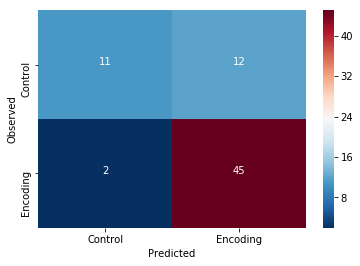

In [9]:
my_first_svc = SVC(kernel='linear') #define the model
my_first_svc.fit(X_train, y_train) #train the model

# predict the training data based on the model
y_pred = my_first_svc.predict(X_train)

# calculate the model accuracy
acc = my_first_svc.score(X_train, y_train)

# calculate the model precision, recall and f1 in one report
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred)

# print results
print('accuracy:', acc)
print(cr)
print(cm)

# plot confusion matrix (training data)
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [10]:
#set up cross-validation to evaluate model performance
#within 10 folds of training set

# predict
y_pred = cross_val_predict(my_first_svc, X_train, y_train,
                           groups=y_train, cv=10)
# scores
acc = cross_val_score(my_first_svc, X_train, y_train,
                     groups=y_train, cv=10)

#Look at accuracy of prediction for each fold of the cross-validation
for i in range(10):
    print('Fold %s -- Acc = %s'%(i, acc[i]))

Fold 0 -- Acc = 0.75
Fold 1 -- Acc = 0.75
Fold 2 -- Acc = 0.75
Fold 3 -- Acc = 0.7142857142857143
Fold 4 -- Acc = 0.7142857142857143
Fold 5 -- Acc = 0.7142857142857143
Fold 6 -- Acc = 0.8571428571428571
Fold 7 -- Acc = 0.6666666666666666
Fold 8 -- Acc = 0.6666666666666666
Fold 9 -- Acc = 0.8333333333333334


Accuracy: 0.7428571428571429
              precision    recall  f1-score   support

         CTL       0.65      0.48      0.55        23
         Enc       0.77      0.87      0.82        47

   micro avg       0.74      0.74      0.74        70
   macro avg       0.71      0.68      0.69        70
weighted avg       0.73      0.74      0.73        70



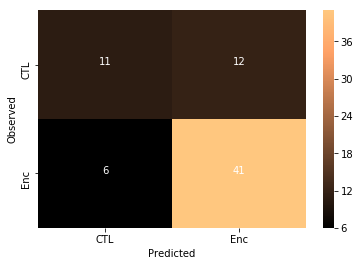

In [11]:
#look at the overall accuracy of the model

overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['CTL','Enc'], columns = ['CTL','Enc'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

Text(0, 0.5, 'subjects')

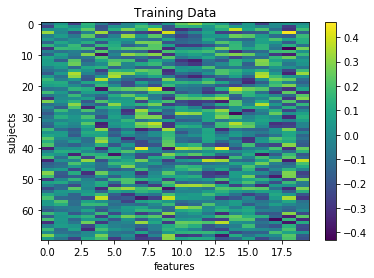

In [12]:
#Scale the training data
scaler = MinMaxScaler().fit(X_train)
X_train_scl = scaler.transform(X_train)

plt.imshow(X_train, aspect='auto')
plt.colorbar()
plt.title('Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Text(0, 0.5, 'subjects')

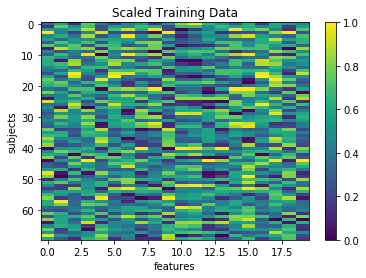

In [13]:
plt.imshow(X_train_scl, aspect='auto')
plt.colorbar()
plt.title('Scaled Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Accuracy: 0.7857142857142857
              precision    recall  f1-score   support

         CTL       0.72      0.57      0.63        23
         Enc       0.81      0.89      0.85        47

   micro avg       0.79      0.79      0.79        70
   macro avg       0.76      0.73      0.74        70
weighted avg       0.78      0.79      0.78        70



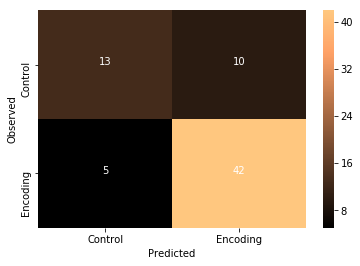

In [14]:
#Repeat steps with scaled data

# predict
y_pred = cross_val_predict(my_first_svc, X_train_scl, y_train,
                           groups=y_train, cv=10)

# get scores
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

# plot
thresh = overall_cm.max() / 2
cmdf = pd.DataFrame(overall_cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

accuracy = 0.8085106382978723
              precision    recall  f1-score   support

         CTL       0.73      0.69      0.71        16
         Enc       0.84      0.87      0.86        31

   micro avg       0.81      0.81      0.81        47
   macro avg       0.79      0.78      0.78        47
weighted avg       0.81      0.81      0.81        47



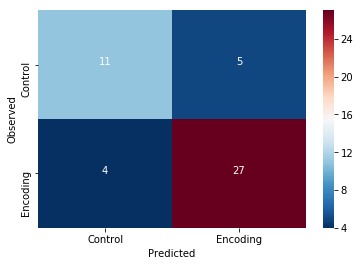

In [15]:
# Test model on unseen data from the test set
# Use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
X_test_scl = scaler.transform(X_test)

my_first_svc.fit(X_train_scl, y_train) # fit to training data
y_pred = my_first_svc.predict(X_test_scl) # classify age class using testing data
acc = my_first_svc.score(X_test_scl, y_test) # get accuracy
cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = pd.DataFrame(cm, index = ['Control','Encoding'], columns = ['Control','Encoding'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

In [16]:
#Visualize feature weights? (color-coded?)

coef_ = my_first_svc.coef_[0]
print(coef_.shape)
print(coef_)

(20,)
[ 0.24103356 -0.46919637  0.56276568 -0.42445484  0.42984412  0.18097025
  1.1038256  -1.1776612   0.67517402  0.21004485 -0.43132687 -0.8573792
  0.13429622 -0.29960362  0.938909    0.67301725  0.35527684 -0.86417118
 -0.58431894 -0.31914206]


In [17]:
# To interpret MIST parcellation labels:
# https://simexp.github.io/multiscale_dashboard/index.html
basc_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcellations'
basc = image.load_img(os.path.join(basc_dir, 'MIST_20.nii'))

print(basc.header.get_data_shape())
#print(basc.header)

b_labels = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MIST/Release/Parcel_Information/MIST_20.csv'
basc_labels = pd.read_csv(b_labels, sep=';')

print(basc_labels.iloc[:, 0:3])

(53, 64, 52)
    roi            label                                               name
0     1          BG_THAL                         BASAL_GANGLIA_and_THALAMUS
1     2         MOTnet_v                        SOMATOMOTOR_NETWORK_ventral
2     3      ORBcor_NACC         ORBITOFRONTAL_CORTEX_and_NUCLEUS_ACCUMBENS
3     4            ASCER                             ASSOCIATIVE_CEREBELLUM
4     5  PGACcor_VMPFcor  PERIGENUAL_ANTERIOR_CINGULATE_CORTEX_and_VENTR...
5     6       ITgyr_Tpol          INFERIOR_TEMPORAL_GYRUS_and_TEMPORAL_POLE
6     7          FPTCnet               FRONTO_PARIETAL_TASK_CONTROL_NETWORK
7     8      AUDnet_PINS              AUDITORY_NETWORK_and_POSTERIOR_INSULA
8     9          MVISnet                              MEDIAL_VISUAL_NETWORK
9    10   AMY_HIPP_Pisul   AMYGDALA_and_HIPPOCAMPUS_and_Peri_Insular_Sulcus
10   11         MOTnet_d                         SOMATOMOTOR_NETWORK_dorsal
11   12        VATTnet_m                   VENTRAL_ATTENTION_NETWORK_medial

In [18]:
basc_labels.insert(loc=3, column='coef', value=coef_, allow_duplicates=True)

print(basc_labels.iloc[:, 2:4])

                                                 name      coef
0                          BASAL_GANGLIA_and_THALAMUS  0.241034
1                         SOMATOMOTOR_NETWORK_ventral -0.469196
2          ORBITOFRONTAL_CORTEX_and_NUCLEUS_ACCUMBENS  0.562766
3                              ASSOCIATIVE_CEREBELLUM -0.424455
4   PERIGENUAL_ANTERIOR_CINGULATE_CORTEX_and_VENTR...  0.429844
5           INFERIOR_TEMPORAL_GYRUS_and_TEMPORAL_POLE  0.180970
6                FRONTO_PARIETAL_TASK_CONTROL_NETWORK  1.103826
7               AUDITORY_NETWORK_and_POSTERIOR_INSULA -1.177661
8                               MEDIAL_VISUAL_NETWORK  0.675174
9    AMYGDALA_and_HIPPOCAMPUS_and_Peri_Insular_Sulcus  0.210045
10                         SOMATOMOTOR_NETWORK_dorsal -0.431327
11                   VENTRAL_ATTENTION_NETWORK_medial -0.857379
12                       DEFAULT_MODE_NETWORK_lateral  0.134296
13                 DEFAULT_MODE_NETWORK_posteromedial -0.299604
14                             LATERAL_V